# Training Tension Models
---
> Graph neural network model for vertex dynamics and tension prediction

**To-Do**👷🚧
- Find good features `x_v` (nodes) and `x_e` (edges)
    - `x_v`:node features to try:
        - [ ] The **Cartesian `u=(x,y)` coordinates**: find number of past velocities (window size `w`). 
        - [ ] The **append norm `[|u|, u_1, u_2]`**, where I separate length from direction (vector). Same `w`.
    - `x_e`: edge features to try:
        - [ ] add **edge length changes** (ie `x_e = dl(t; t=T-1...T-w), e[s,t]` ); edge vector (`e[s,t] = v_pos[t]-v_pos[s]`).
        $\{l_{ij}(t)\}_{t=T-1...T-w } = (x_v[tgt]- x_v[src])$
- Model architecture:
    - [ ] add *Cell layer* processor
- Rollout error (tension, position/velocity)
    - rollout vs 1-step losses
    - train for single step with velocity noise (Brownian noise: Sanchez-Gonzalez, *et al.* \[ASG2020\])
    - train for rollout (multi-step loss)
    - convert vel-y error to **position error**, e.g. "speed"+"direction"(angle/dot product etc.)
- compare MLP vs CONV layers for message passing.
- try with dynamic graphs (construct graphs on the fly based on relative positions, and use cell edges and cell attrib only for queries on `Y_edge`, `Y_cell`).

**Node-to-Cell Encoding/Pooling Layer**:
1. Initiate node-to-cell edge attr-s as (source) node attr-s `x[node2cell_index[0]]`.
1. Compute node-to-cell edge attr-s using MLP: `e_n2c = MLP( x[node2cell_index[0]] )`
1. Aggregate node-to-cell edge attr-s as cell attr-s : `x_cell = Aggregate(e_n2c)`
1. Compute new cell attr-s using (encodes `x_cell` into cell attr-s) : `h_cell = MLP_Cell_encoder( x_cell )`

```python
n2c_model = mlp(...) # "message", just node-wise MLP
cell_aggr = Aggregate()
cell_enc = mlp(...)

e_n2c = n2c_model(data.x)[data.node2cell_index[0]]
x_cell = cell_aggr(data.cell_pressures.size(0), data.node2cell_index, e_n2c)
h_cell = cell_enc(x_cell)
```

---
- **Adding noise from M steps**: Sum of M normal rand. var-s results in normal var. w/ variance M and s.t.d.=sqrt(M):
```python
x = np.random.normal(size=(5,1000))
y = x.sum(axis=0)
z = np.random.normal(size=(1,1000))*np.sqrt(5)
plt.hist(x.ravel(),bins=50,label='x',density=True)
plt.hist(y        ,bins=50,label='y',density=True)
plt.hist(z.ravel(),bins=50,label='z',density=True,alpha=.5)
plt.legend();
```

---

In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [137]:
from collections import OrderedDict
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies, HaraAblation
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, RecoilAsTension, TransformTension
from simgnn.transforms import AppendReversedEdges, AppendEdgeNorm, AppendDiff_x, Reshape_x, AppendEdgeLen
# from torch_geometric.utils import to_undirected as T_undir

In [138]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Data, Stat-s, Transforms

Notes for normalisation param-s:

- Use `simgnn.transforms` to normalise real--Hara movies and ablation,  and simulated movies.
- For ablation movies, convert to  HaraMovies length scale (pixels) and use same `l_av` as for HaraMovies dataset.

---
|Dataset| Avg. edge len.|Tension/Recoil| Transforms (Normalisation)|Notes|
|:---:|:---:|---:|:---|:---:|
|`single_distr_sims` | 1.08 a.u. | range = [0.00131, 4.26]; sd=0.637; median=0.305; mean=0.578; | `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/o base tension |
|`unimodal_wbasetens_sims` | 0.906 a.u. | range=[0.407, 5.47]; sd=0.729; median=1.48; mean=1.6| `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/ non-zero base tension |
|`HaraMovies`  | 26.32 pixels||`[Pos2Vec(scale=10*26.32)`, `ScaleVelocity(0.5*26.32)]`| tissue movies w/o force data|
|`HaraAblation`|$26.32\cdot\frac{0.4}{0.21}$ pixels| range=[0.0239, 2.61]; sd=0.651; median=0.673; mean=0.826 | `[Pos2Vec(scale=10*50.13), ScaleVelocity(0.5*50.13)]`| short movies w/ recoil data; frame rate:dataset contains vertex positions only from every 10th frame |


### Datasets

---
- **Normalisation param-s**

In [139]:
# Data normalisation param-s : sim="default" for simulation data
# Average edge lengths
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

# Stat-s for raw tension/recoil values
t_av = {'sim':0.6, 'single_distr_sims': 0.58, 'unimodal_wbasetens_sims': 1.6, 'abln': 0.83}
t_sd = {'sim':0.63, 'single_distr_sims': 0.64, 'unimodal_wbasetens_sims':0.73 , 'abln': 0.65}

**Input features and normalisation param-s (transforms)**

In [205]:
# Input features
window_size = 5
pos_noise = torch.normal
noise_args=[0,1]
print(f'> Set features window size to --> {window_size}')

# Simulation dataset
Tnrm = {k: [Pos2Vec(scale=10*l_0[k], pos_noise=pos_noise, noise_args=noise_args) ,
            ScaleVelocity(0.5*l_0[k]),
            ScaleTension(t_sd[k], shift=t_av[k]),
           ]
        for k in ['sim', 'single_distr_sims', 'unimodal_wbasetens_sims']}

# Hara ablation dataset
Tnrm['abln'] = [Pos2Vec(scale=10*l_0['abln'], pos_noise=pos_noise, noise_args=noise_args),
                ScaleVelocity(0.5*l_0['abln']),
                RecoilAsTension(), 
                ScaleTension(t_sd['abln'], shift=t_av['abln']),
               ]

# Hara movie dataset
Tnrm['hara'] = [Pos2Vec(scale=10*l_0['hara'], pos_noise=pos_noise, noise_args=noise_args),
                ScaleVelocity(0.5*l_0['hara'])]

# Node and Edge Feature Transforms
for k in Tnrm:
    # to undirected graph: add e_ji for all e_ij
    Tnrm[k].append(AppendReversedEdges())
    
    # Add edge features
    Tnrm[k].append(AppendDiff_x())
    Tnrm[k].append(AppendEdgeNorm())
    Tnrm[k].append(AppendEdgeLen(norm=True, scale=l_0[k])) # for edge masks
    
    # flatten  node features
    Tnrm[k].append(Reshape_x((-1,window_size*2)))
    
    Tnrm[k] = T.Compose(Tnrm[k])

> Set features window size to --> 5


In [206]:
Tnrm['sim']

Compose([
    Pos2Vec(norm=True, scale=10.0, cat=False, pos_noise=normal, noise_args=[0, 1], noise_kwargs={}),
    ScaleVelocity(scale=0.5),
    ScaleTension(scale=0.63, shift=0.6),
    AppendReversedEdges(reverse_attr=True, reverse_tension=False, edge_id=True),
    AppendDiff_x(norm=True),
    AppendEdgeNorm(N_dim=2),
    AppendEdgeLen(keep_dir=False, aggr_edge_id=True, use_edge_attr=False, norm=True, scale=1.0),
    Reshape_x((-1, 10)),
])

**Load datasets**

- if a new `w` parameter is set, delete the older *processed* dataset files

In [134]:
!rm -dr simgnn_data/single_distr_sims/train/processed
!rm -dr simgnn_data/single_distr_sims/val/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
!rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed

!rm -dr simgnn_data/hara_movies/processed/
!rm -dr simgnn_data/hara_ablation/processed/

# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
# !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/

In [207]:
hara_abln = HaraAblation('simgnn_data/hara_ablation/', window_size=window_size, transform=Tnrm['abln'], smoothing=True, sma_lag_time=3)
hara = HaraMovies('simgnn_data/hara_movies/',window_size=window_size, transform=Tnrm['hara'], smoothing=True, sma_lag_time=4)

# Hara movie datasets
# seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg001_raw = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorm_hara)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size, transform=Tnorm_hara,smoothing=True, sma_lag_time=4)

# Simulation datasets
# rand base contractility
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size,
#                       transform=Tnrm['sim']
                      transform=Tnrm['unimodal_wbasetens_sims']
                     )
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size,
#                           transform=Tnrm['sim']
                          transform=Tnrm['unimodal_wbasetens_sims']
                         )

# w/o base contractility
sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size,
#                       transform=Tnrm['sim']
                      transform=Tnrm['single_distr_sims']
                     )
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size,
#                           transform=Tnrm['sim']
                          transform=Tnrm['single_distr_sims']
                         )


datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2': sim2_val,
                 'hara' : hara,
                 'abln': hara_abln}
dataset_legend={'train': 'Train(sim1)',
                'val': 'Val(sim1)',
                'val2': 'Val(sim2)',
                'hara': 'Hara',
                'abln': 'Recoil'}

In [121]:
# k = 'val2'
# t = 15
# print('{}\n{} : {}\nsize:{}\n\nFrame {}:\n{}'.format(dataset_legend[k],k,datasets_dict[k],len(datasets_dict[k]),t,datasets_dict[k][0]))
# plt.figure(figsize=[2.5,2.5])
# nx.draw(to_networkx(datasets_dict[k][t]),pos=dict(enumerate(datasets_dict[k][t].pos.numpy())), node_size=10)

**Persistence Losses**

In [122]:
# print('Persistence:')
# for k in datasets_dict:
#     if k=='abln':print('Ignoring ablation data velocity');continue
#     print(f'\t- {dataset_legend[k]}: {persistence_loss(datasets_dict[k])}')
    
# print(len(datasets_dict['train']))

---

## Tension Models

In [208]:
from simgnn.train import train_model, write_log, load_log, plot_losses
from simgnn.train import predict, predict_batch, plot_velocity_predictions, plot_tension_prediction
from simgnn.train import predict_abln_tension, predict_dataset_tension

from scipy.stats import pearsonr


# from simgnn.nn import mlp, IndependentBlock, MessageBlock, dims_to_dict, Encode_Process_Decode
from simgnn.models import construct_simple_gnn, GraphEncoder, GraphDecoder, GraphProcessor

In [52]:
# MessageBlock(..., hidden_dims=[16], updt='p')

In [53]:
# next(iter(loaders['train']))

- Construct a model

In [54]:
# torch.manual_seed(0)

# # GNN architecture (if dim is `int` latent dims nodes=edges)
# # -----
# input_dims = OrderedDict([('node', 10), ('edge', 2)]) # node_features, edge_features
# output_dims = OrderedDict([('node', 2), ('edge', 1)]) # velocity:(Nv,2), tensions:(Ne,1)
# latent_dims = 128

# encoder_kwrgs    = {'hidden_dims':[64]}

# processor_kwargs = {'n_blocks': 10,
#                     'block_type': 'message',
#                     'is_residual': True,
#                     'seq': 'n', # 'n', 'e', 'p'
#                     'norm_type': 'bn', # 'ln' or 'bn'
#                     'block_p': 0,  # block dropout (last layer)
#                     'dropout_p': 0, # dropout for hidden layers (if any)
#                     'hidden_dims':[64]
#                    }

# decoder_kwargs   = {'hidden_dims':[64, 32, 8]}

# net = construct_simple_gnn(input_dims, latent_dims, output_dims,
#                            encoder_kwrgs=encoder_kwrgs,
#                            processor_kwargs=processor_kwargs, 
#                            decoder_kwargs=decoder_kwargs).to(device)

# unique_id = 'NoNrmNoDiffX'#net.__class__.__name__  # set unique name for the model
# save_dir = './simgnn_data/saved_models/'

In [209]:
import simgnn.hardcoded as hcmodels # hardcoded models for testing and experimentation

torch.manual_seed(0)
# net, unique_id = hcmodels.get_model_04122021()
net, unique_id = hcmodels.get_model_YesNrmYesDiffX(return_name=True)
print('unique_id:', unique_id)
net = net.to(device)

# unique_id: 'YesNrmYesDiffX', 'NoNrmNoDiffX', 'YesNrmNoDiffX', 'model_04122021'

# save_dir = './simgnn_data/saved_models/tension_test'
save_dir = './simgnn_data/saved_models/'

unique_id: YesNrmYesDiffX


- Training param-s and loaders:

In [210]:
# Training param-s & Data loaders:
# -----
num_epochs = 30
lr = 0.0001
bs = 2
loss_func = torch.nn.MSELoss(reduction='mean')

opt = torch.optim.Adam(net.parameters(), lr=lr) # SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = None # torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs),
           'val':    DataLoader(datasets_dict['val'],  batch_size=bs)
          }
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {'train':[True,False], 
                  'val':[True, False],
                  'val2':[True,False] ,
                  'abln':[True,False] ,
                  'hara' : [False, False]
                 }# [tension, pressure]

return_best = False
ignore_short_edges, edge_len_threshold = False, 10**-3


model_name = datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+f'_{unique_id}_bs{bs}w{window_size}{"best" if return_best else ""}'
print(model_name)

30122021_062553_YesNrmYesDiffX_bs2w5


In [211]:
print(model_name,end='\n---\n')

net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=scheduler, device=device, model_states = model_states,
                             loss_func = loss_func, use_force_loss=use_force_loss, return_best=return_best,
                             ignore_short_edges = ignore_short_edges, edge_len_threshold = edge_len_threshold)

30122021_062553_YesNrmYesDiffX_bs2w5
---
Training param-s: #epochs=30, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/29: train_loss_tot=   0.943; train_loss_y= 0.01102; train_loss_T=   0.932; |val_loss_tot=   0.859; |10s
Epoch 1/29: train_loss_tot=  0.8382; train_loss_y=0.006463; train_loss_T=  0.8317; |val_loss_tot=   0.782; |19s
Epoch 2/29: train_loss_tot=  0.7221; train_loss_y=0.005419; train_loss_T=  0.7167; |val_loss_tot=   0.701; |29s
Epoch 3/29: train_loss_tot=  0.6707; train_loss_y=0.005053; train_loss_T=  0.6657; |val_loss_tot=  0.6761; |38s
Epoch 4/29: train_loss_tot=  0.6392; train_loss_y=0.004602; train_loss_T=  0.6346; |val_loss_tot=   0.658; |48s
Epoch 5/29: train_loss_tot=  0.6154; train_loss_y=0.004285; train_loss_T=  0.6111; |val_loss_tot=  0.6255; |58s
Epoch 6/29: train_loss_tot=   0.595; train_loss_y= 0.00407; train_loss_T=  0.5909; |val_loss_tot=  0.6322; |67s
Epoch 7/29: train_loss_tot=  0.5766; train_loss_y=0.003871; train_l

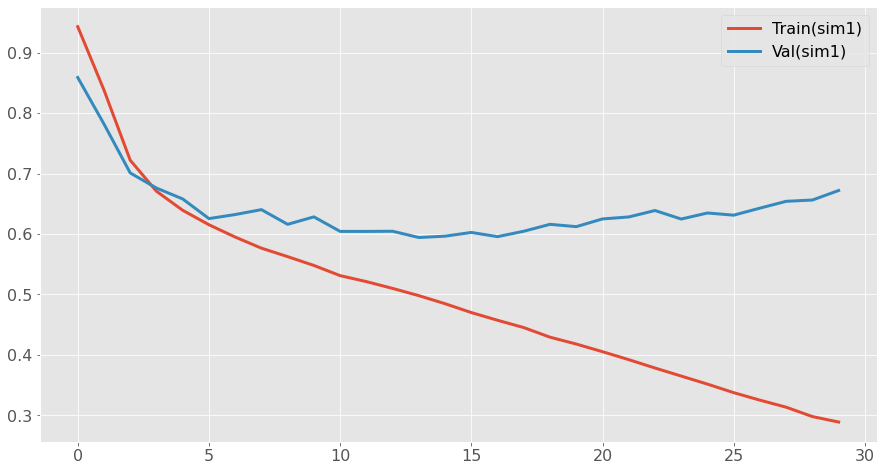

In [213]:
# plot losses
plot_losses(train_log, loaders, dataset_legend)
# plt.show()

In [47]:
# # # Save trained model # # #
# write_log(f'{path.join(save_dir, model_name)}_train_log.pkl',train_log)
# torch.save(net.state_dict(), f'{path.join(save_dir, model_name)}_net.pkl')
# print(f'Model weights saved in \n{path.join(save_dir, model_name)}_net.pkl')

- train_loss_tot =0.40524689748152837;
- train_loss_y =0.005150240812315999;
- train_loss_T =0.40009665666921235;
- train_loss_P =0.0;
- val_loss_tot =0.6744702257348677;
- val_loss_y =0.004624213330047315;
- val_loss_T =0.6698460124048203;
- val_loss_P =0.0;
- val2_loss_tot =0.6324190501097198;
- val2_loss_y =0.004126334740817295;
- val2_loss_T =0.6282927153689025;
- val2_loss_P =0.0;
- hara_loss_tot =0.001477201388266914;
- hara_loss_y =0.001477201388266914;
- hara_loss_T =0.0;
- hara_loss_P =0.0;



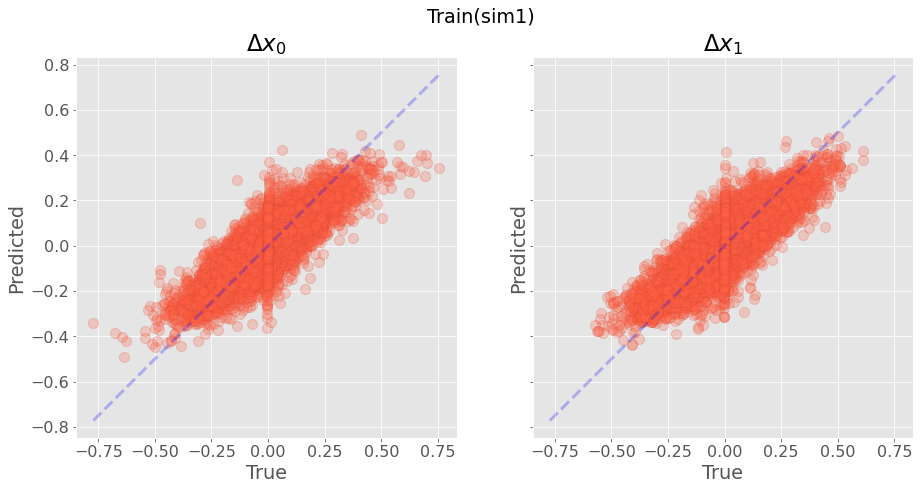

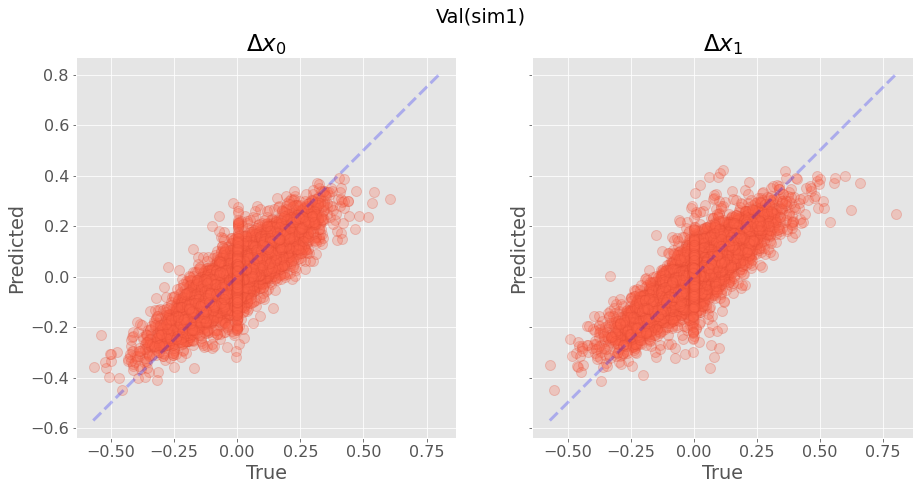

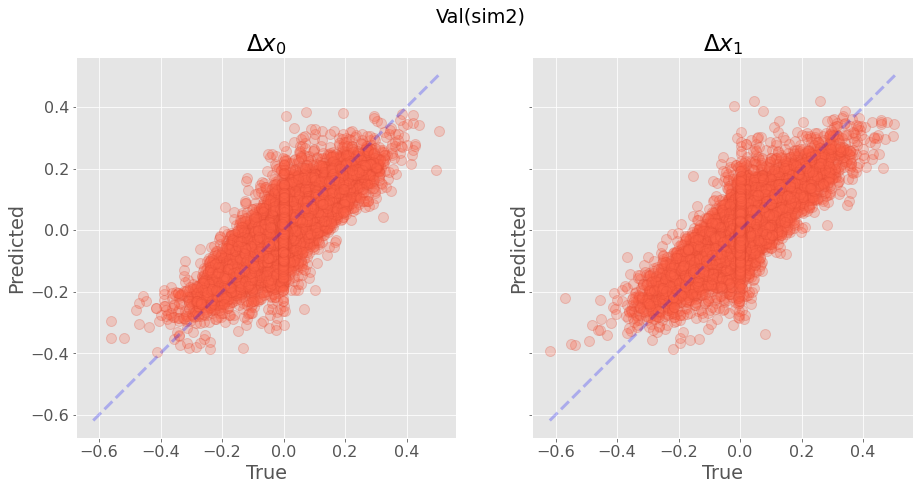

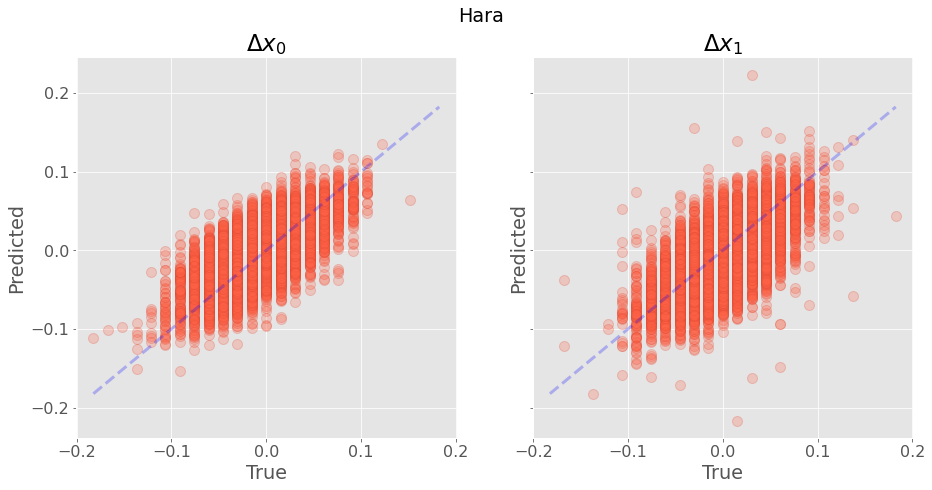

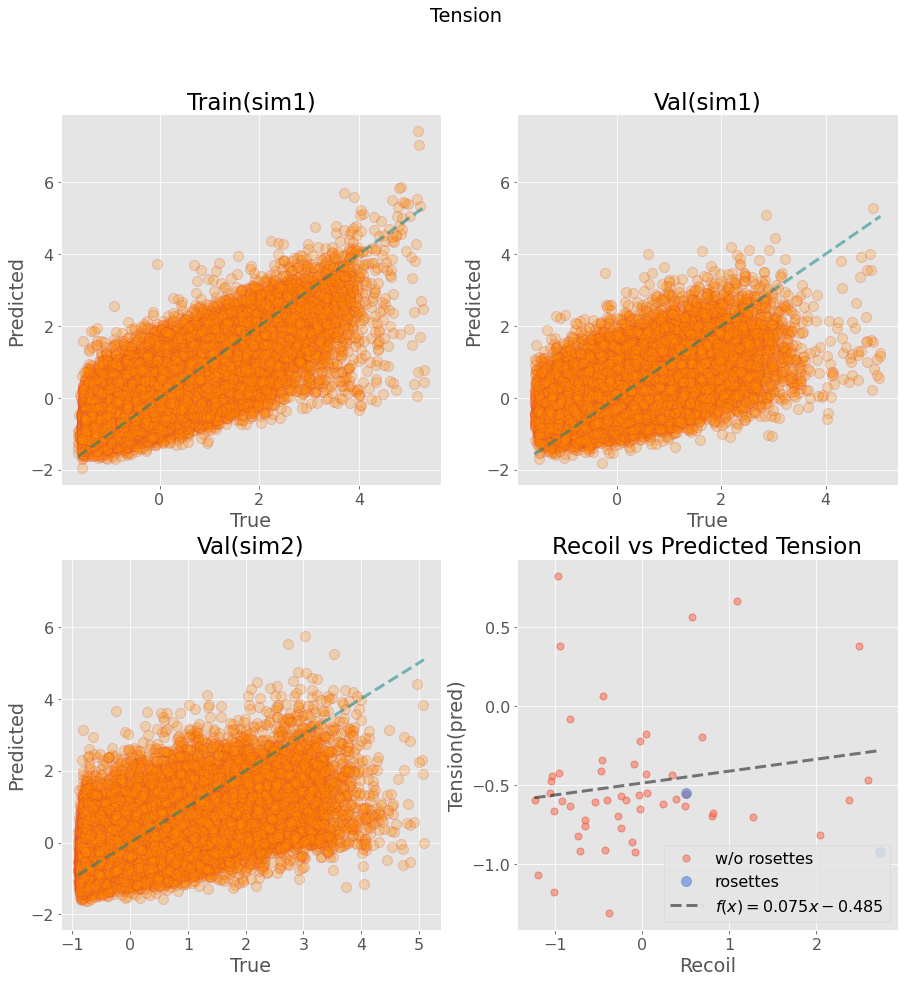

- - - - - - - - - - -
NO___rosettes : R,p=(0.1649619770042013, 0.24253738827508736)
WITH_rosettes : R,p=(0.09700501253207516, 0.4852978359181862)
- - - - - - - - - - -


In [214]:
# compute predictions and plot them
# vel-y, tens, pres
bs = 2

pred_out, tgt_out, sample_losses = predict_batch(net,
                                                 {
                                                  'train' : DataLoader(datasets_dict['train'], batch_size=bs),
                                                  'val':    DataLoader(datasets_dict['val'],  batch_size=bs),
                                                  'val2':   DataLoader(datasets_dict['val2'], batch_size=bs),
                                                  'hara':   DataLoader(datasets_dict['hara'], batch_size=bs)},
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {'train': True, 'val': True, 'val2': True, 'hara': False},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend)

axs = plot_tension_prediction(pred_out[1], tgt_out[1], dataset_legend,figsize=[15,15],nrows=2,ncols=2)

# # # # # # # # # # # # # #
# # # Hara Ablation # # # #
# # # # # # # # # # # # # #
Tp, Tt, is_ros_ = predict_abln_tension(net, datasets_dict['abln'], device=device)

m1,m2 = np.polyfit(Tt[~is_ros_], Tp[~is_ros_], 1)
y_fit = np.array([min(Tt),max(Tt)])*m1+m2

# plt.figure(figsize=[6,6])
ax = axs.ravel()[-1]
ax.plot(Tt[~is_ros_], Tp[~is_ros_], 'o', mfc='tomato', ms=7, alpha=.5, label='w/o rosettes')
ax.plot(Tt[is_ros_], Tp[is_ros_], 'o', mfc='royalblue', ms=10, alpha=.5, label='rosettes')

ax.plot([min(Tt),max(Tt)], y_fit, 'k--',lw=3, alpha=.5, label=f'$f(x)={m1:.3f}x{"+" if m2>0 else "-"}{np.abs(m2):.3f}$')
ax.set_title('Recoil vs Predicted Tension');
ax.set_xlabel('Recoil');
ax.set_ylabel('Tension(pred)');
# ax.axis([-1, max(Tt), y_fit[0], y_fit[1]])
ax.legend();

plt.show()
print('- '*10+'-')
print(f'NO___rosettes : R,p={pearsonr(Tt[~is_ros_], Tp[~is_ros_])}')
print(f'WITH_rosettes : R,p={pearsonr(Tt, Tp)}')
print('- '*10+'-')

---

**Check tension prediction, losses, and plots**

train MSE: 0.40166308285084
val MSE: 0.6701643740981055
val2 MSE: 0.6294378910002384


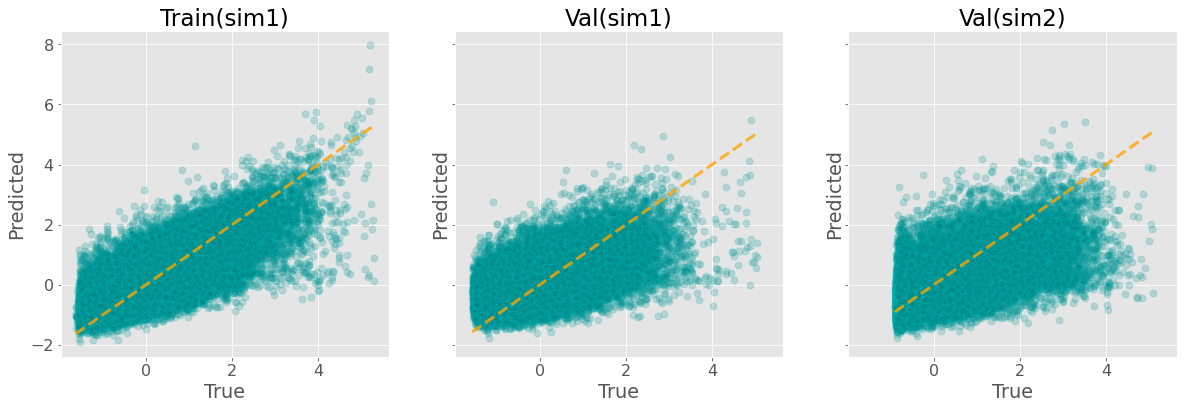

In [215]:
# # Predict for each sample w/o batching:

_, axs = plt.subplots(ncols=3, figsize=[20, 6], sharex=True, sharey=True)

tension_preds = {}
tension_trues = {}

for dataset_k, ax in zip(['train', 'val', 'val2'], axs):
    Tp, Tt =  predict_dataset_tension(net, datasets_dict[dataset_k],device=device)
    tension_preds[dataset_k] = Tp
    tension_trues[dataset_k] = Tt

    minmaxY = [np.min(np.concatenate([k.ravel() for k in Tt])),
               np.max(np.concatenate([k.ravel() for k in Tt]))] 

    ax.plot(np.concatenate([k.ravel() for k in Tt]),
            np.concatenate([k.ravel() for k in Tp]),
            'o', ms=7, c='c', mfc='teal', alpha=.2)
    ax.plot(minmaxY, minmaxY, '--', color='orange', lw=3, alpha=.8)
    ax.set_title(dataset_legend[dataset_k]);
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    
    sum_l2_losses, Nsamples = np.array([(((Tp_k-Tt_k)**2).sum(), Tp_k.shape[1])
                                    for Tp_k, Tt_k in zip(tension_preds[dataset_k], tension_trues[dataset_k])]).sum(axis=0)
    print(f'{dataset_k} MSE:', sum_l2_losses/Nsamples)

In [216]:
dataset_k = 'train'

l2_loss = torch.nn.MSELoss(reduction='mean')
print('torch.nn.MSE:', l2_loss(torch.from_numpy(np.concatenate([T_k.ravel() for T_k in tension_trues[dataset_k]])),
                               torch.from_numpy(np.concatenate([T_k.ravel() for T_k in tension_preds[dataset_k]]))) )

torch.nn.MSE: tensor(0.4017)


### Simulation Datasets as Movies

In [217]:
dataset_mov_names = {}
dataset_mov_idx = {}
dataset_mov = {}

for dataset_k in ['train', 'val', 'val2']:
    print(dataset_k)

    d_names_list = [k.split('_')[2] for k in datasets_dict[dataset_k].processed_file_names]
    
    dataset_mov_names[dataset_k] = {k : ki for ki, k in enumerate(np.unique(d_names_list))}
    
    dataset_mov_idx[dataset_k] = torch.tensor([dataset_mov_names[dataset_k][k] for k in d_names_list])
    
    dataset_mov[dataset_k] = {k:datasets_dict[dataset_k][dataset_mov_names[dataset_k][k]==dataset_mov_idx[dataset_k]]
                              for k in dataset_mov_names[dataset_k]}
dataset_mov

train
val
val2


{'train': {'sim000': VertexDynamics(56),
  'sim001': VertexDynamics(56),
  'sim002': VertexDynamics(56),
  'sim003': VertexDynamics(56),
  'sim004': VertexDynamics(56)},
 'val': {'sim005': VertexDynamics(56), 'sim006': VertexDynamics(56)},
 'val2': {'sim005': VertexDynamics(56), 'sim006': VertexDynamics(56)}}

### Model Predictions for Movies
> Predict `(Velocity[T+1], Tension[T])` for movies

In [218]:
from simgnn.train import np_loss_wrt_time, predict_abln_tension, predict_dataset_tension, predict_dataset

from scipy.stats import pearsonr

In [219]:
velocity_scale = {'train':1.1*.5, 'val':1.1*.5, 'val2':0.91*.5, 'hara':26.32*.5, 'abln':50.13*.5}

In [220]:
ignore_short_edges, edge_len_threshold = True, 10**-3

In [221]:
model_results = {}
loss_type = 'mse'

for dataset_k in dataset_mov:
    print('-'*10+'\n'+dataset_k)
    model_results[dataset_k] = {}
    for mov_k in dataset_mov[dataset_k]:
        print('\t',mov_k,f': len={len(dataset_mov[dataset_k][mov_k])};',
              f'E_n={dataset_mov[dataset_k][mov_k][0].edge_tensions.size(0)};',
              f'V_n={dataset_mov[dataset_k][mov_k][0].num_nodes};',
              f'C_n={dataset_mov[dataset_k][mov_k][0].num_cells};', end=' ')

        model_results[dataset_k][mov_k] = predict_dataset(net, dataset_mov[dataset_k][mov_k],device=device, concat=True)
        
        edge_index = dataset_mov[dataset_k][mov_k][0].edge_index[:,torch.unique(dataset_mov[dataset_k][mov_k][0].edge_id)]
        model_results[dataset_k][mov_k]['edge_index'] = edge_index
        
        pos = np.concatenate([d.pos.reshape(1,-1,2) for d in dataset_mov[dataset_k][mov_k]],axis=0)
        model_results[dataset_k][mov_k]['targets']['pos'] = pos
        
        edge_lengths = np.linalg.norm(pos[:, edge_index[1],:] - pos[:, edge_index[0],:], axis=-1)
        model_results[dataset_k][mov_k]['targets']['edge_lengths'] = edge_lengths
        
        dx_unnorm = velocity_scale[dataset_k]*model_results[dataset_k][mov_k]['predictions']['velocity']
        # pos predictions w/ velocity (except for first pos)
        pos_preds = np.concatenate([pos[:1],(pos+dx_unnorm)[:-1]], axis=0)
        model_results[dataset_k][mov_k]['predictions']['pos'] = pos_preds

        model_results[dataset_k][mov_k]['predictions']['edge_lengths'] = np.linalg.norm(pos_preds[:, edge_index[1],:] - pos_preds[:, edge_index[0],:], axis=-1)
        if ignore_short_edges:
            edge_mask = np.all(np.concatenate([dk.edge_length.numpy().reshape(1,-1)
                                               for dk in dataset_mov[dataset_k][mov_k]], axis=0) > edge_len_threshold, axis=0)
            model_results[dataset_k][mov_k]['predictions']['edge_masks'] = edge_mask
        else:
            model_results[dataset_k][mov_k]['predictions']['edge_masks'] = None
        
        model_results[dataset_k][mov_k]['loss'] = {}
        model_results[dataset_k][mov_k]['loss']['velocity'] = np_loss_wrt_time(model_results[dataset_k][mov_k]['predictions']['velocity'],
                                                                               model_results[dataset_k][mov_k]['targets']['velocity'])
        model_results[dataset_k][mov_k]['loss']['tension'] = np_loss_wrt_time(model_results[dataset_k][mov_k]['predictions']['tension'],
                                                                              model_results[dataset_k][mov_k]['targets']['tension'])
        if ignore_short_edges:
            model_results[dataset_k][mov_k]['loss']['tension_mask'] = model_results[dataset_k][mov_k]['loss']['tension'].copy()
            model_results[dataset_k][mov_k]['loss']['tension_mask'][~edge_mask] = np.nan
        else:
            model_results[dataset_k][mov_k]['loss']['tension_mask'] = None
        model_results[dataset_k][mov_k]['loss']['edge_lengths'] = np_loss_wrt_time(model_results[dataset_k][mov_k]['predictions']['edge_lengths'],
                                                                                   model_results[dataset_k][mov_k]['targets']['edge_lengths'])
        print(f"Losses: Vel-y={model_results[dataset_k][mov_k]['loss']['velocity'].mean():6.4f}; "+
              f"E_len={model_results[dataset_k][mov_k]['loss']['edge_lengths'].mean():6.4f}; "+
              f"Tension={model_results[dataset_k][mov_k]['loss']['tension'].mean():6.4f};"+
             f"Tension(mask)={np.nanmean(model_results[dataset_k][mov_k]['loss']['tension_mask']) if ignore_short_edges else 0.0:6.4f}")

----------
train
	 sim000 : len=56; E_n=339; V_n=240; C_n=100; Losses: Vel-y=0.0056; E_len=0.0016; Tension=0.4153;Tension(mask)=0.3842
	 sim001 : len=56; E_n=223; V_n=160; C_n=64; Losses: Vel-y=0.0053; E_len=0.0015; Tension=0.4032;Tension(mask)=0.3424
	 sim002 : len=56; E_n=223; V_n=160; C_n=64; Losses: Vel-y=0.0041; E_len=0.0011; Tension=0.2720;Tension(mask)=0.2605
	 sim003 : len=56; E_n=275; V_n=196; C_n=80; Losses: Vel-y=0.0047; E_len=0.0013; Tension=0.3872;Tension(mask)=0.3697
	 sim004 : len=56; E_n=339; V_n=240; C_n=100; Losses: Vel-y=0.0057; E_len=0.0015; Tension=0.4840;Tension(mask)=0.4202
----------
val
	 sim005 : len=56; E_n=339; V_n=240; C_n=100; Losses: Vel-y=0.0043; E_len=0.0012; Tension=0.6621;Tension(mask)=0.6101
	 sim006 : len=56; E_n=275; V_n=196; C_n=80; Losses: Vel-y=0.0050; E_len=0.0014; Tension=0.6758;Tension(mask)=0.6132
----------
val2
	 sim005 : len=56; E_n=431; V_n=304; C_n=128; Losses: Vel-y=0.0044; E_len=0.0020; Tension=0.6557;Tension(mask)=0.4152
	 sim006 : l

### Predicted Dynamics

In [57]:
# ['train', 'val', 'val2']['movie_1',...,'movie_N']['predictions', 'targets', 'edge_index']

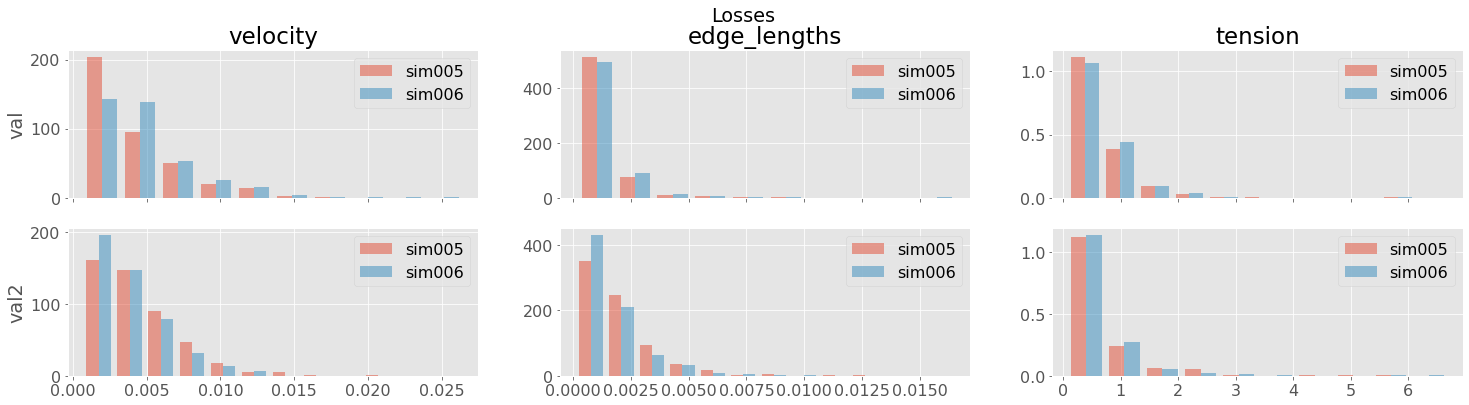

In [222]:
dataset_names = ['val', 'val2'] # list(model_results.keys())

fig, axs = plt.subplots(nrows=len(dataset_names), ncols=3, figsize=[25,1+2.5*len(dataset_names)], sharex='col')

dataset_var_minmax = {}

for dataset_k, ax_k in zip(dataset_names, axs): #zip(, axs):
    dataset_var_minmax[dataset_k] = {}
    for k, var_k in enumerate(['velocity', 'edge_lengths', 'tension']):
        dataset_var_minmax[dataset_k][var_k] = np.array([[np.quantile(model_results[dataset_k][mov_k]['targets'][var_k], 0.01),
                                                          np.quantile(model_results[dataset_k][mov_k]['targets'][var_k], 0.995)]
                                                         for mov_k in model_results[dataset_k]])
        dataset_var_minmax[dataset_k][var_k] = [dataset_var_minmax[dataset_k][var_k][:,0].min(), dataset_var_minmax[dataset_k][var_k][:,1].max()]

        ax_k[k].hist([model_results[dataset_k][mov_k]['loss'][var_k] for mov_k in model_results[dataset_k]],
                     label=[mov_k for mov_k in model_results[dataset_k]], alpha=.5, density=True, stacked=False)
        ax_k[k].legend()
        if dataset_k==dataset_names[0]:
            ax_k[k].set_title(f'{var_k}')
    ax_k[0].set_ylabel(f'{dataset_k}')
plt.suptitle('Losses')
plt.show()

var_limits = {k:np.array([dataset_var_minmax[k_up][k] for k_up in dataset_var_minmax]) for k in ['velocity', 'edge_lengths', 'tension']}
var_limits = {var_k:[var_limits[var_k][:,0].min(), var_limits[var_k][:,1].max()] for var_k in var_limits}

In [223]:
var_limits

{'velocity': [-0.2617666506767273, 0.3144946208596225],
 'edge_lengths': [0.0004144500286201947, 3.003029745817185],
 'tension': [-1.4892891240119934, 3.707299780845643]}

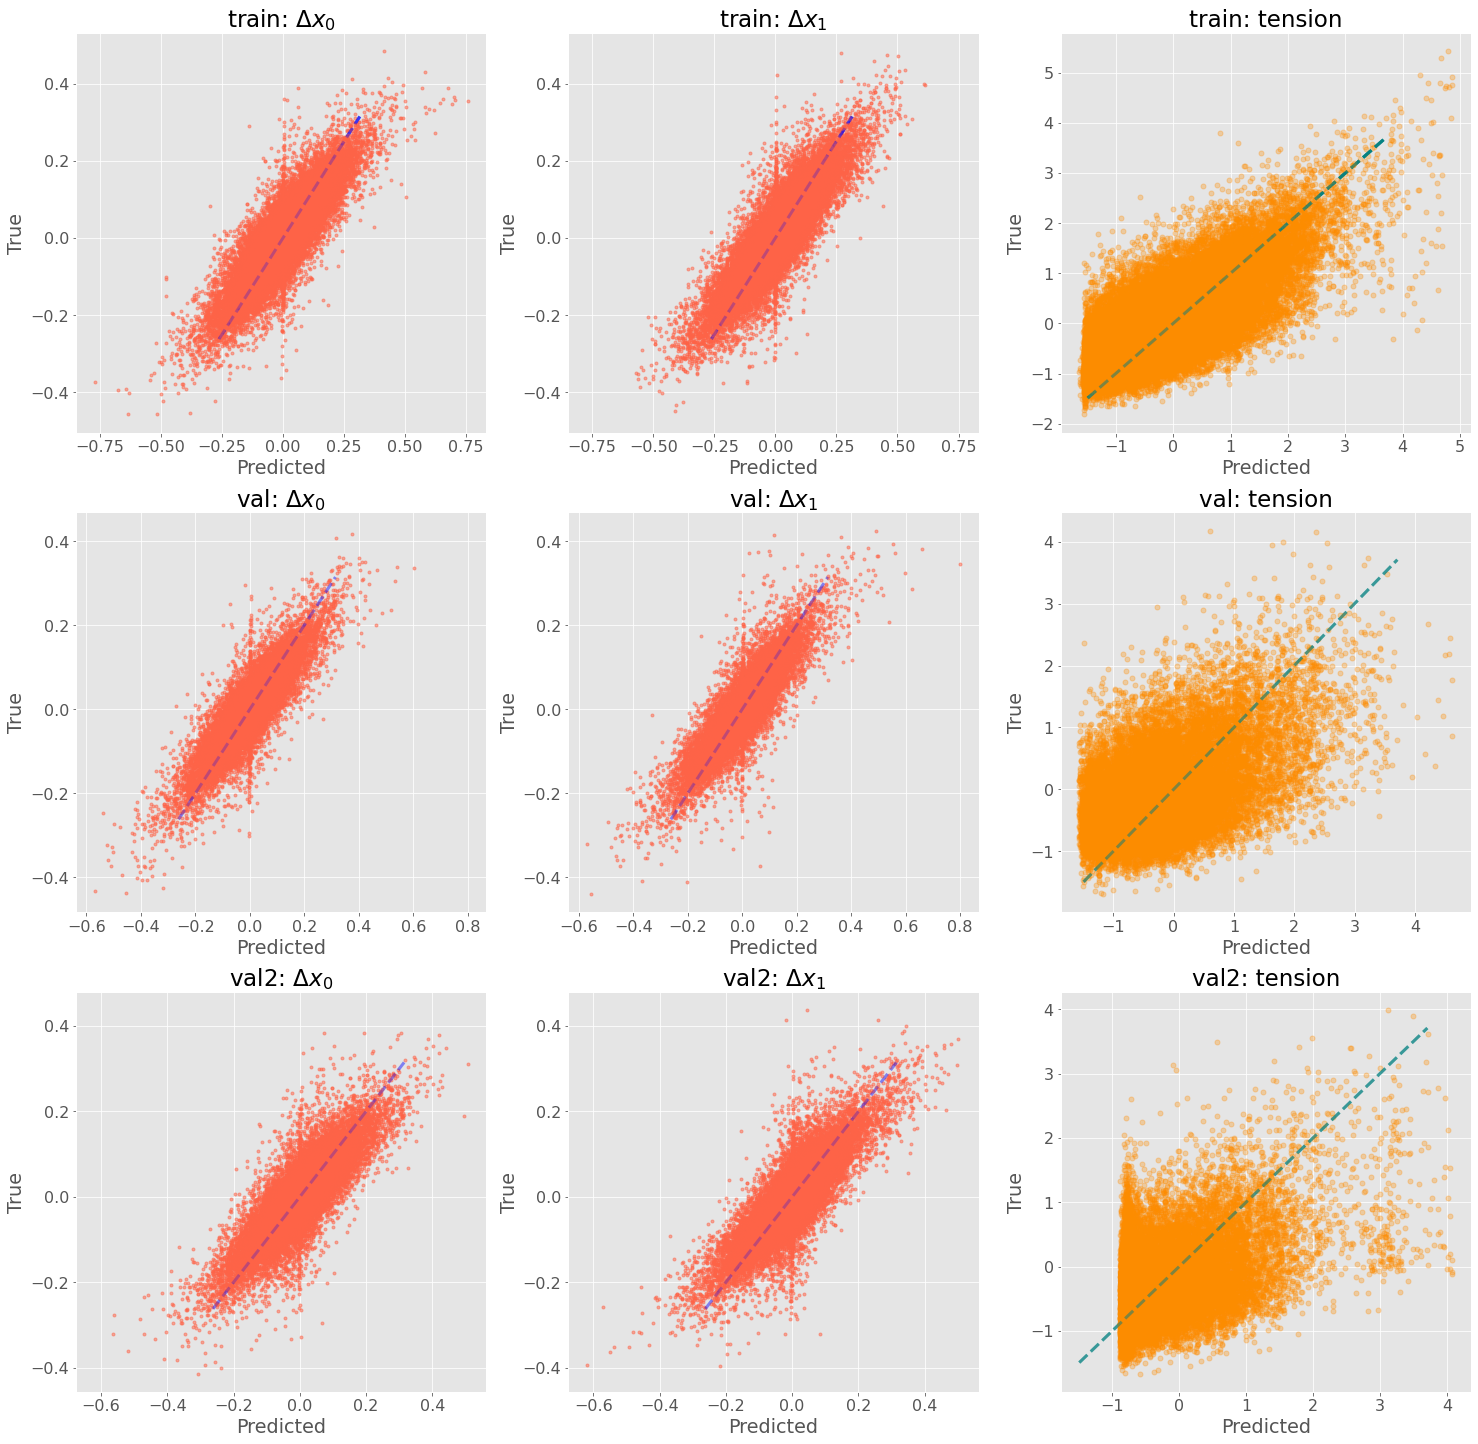

In [225]:
fig, axs = plt.subplots(nrows=len(model_results), ncols=3, figsize=[25,25])
for dataset_k, ax_k in zip(model_results, axs):
    for mov_n in model_results[dataset_k]:
        ax_k[0].plot(model_results[dataset_k][mov_n]['targets']['velocity'][:,:,0].ravel(),
                     model_results[dataset_k][mov_n]['predictions']['velocity'][:,:,0].ravel(), 'o',
                     # label=mov_n,
                     c='tomato',
                     ms=3, alpha=.5)
        ax_k[0].set_ylabel('True')
        ax_k[0].set_xlabel('Predicted')
        ax_k[0].set_title(f'{dataset_k}: '+r'$\Delta{}x_0$')
        ax_k[0].plot(var_limits['velocity'], var_limits['velocity'], '--', color='b', lw=3, alpha=.25)
        
        ax_k[1].plot(model_results[dataset_k][mov_n]['targets']['velocity'][:,:,1].ravel(),
                     model_results[dataset_k][mov_n]['predictions']['velocity'][:,:,1].ravel(), 'o',
                     # label=mov_n,
                     c='tomato',
                     ms=3, alpha=.5)
        ax_k[1].set_ylabel('True')
        ax_k[1].set_xlabel('Predicted')
        ax_k[1].set_title(f'{dataset_k}: '+r'$\Delta{}x_1$')
        ax_k[1].sharex(ax_k[0])
        ax_k[1].sharey(ax_k[0])
        ax_k[1].plot(var_limits['velocity'], var_limits['velocity'], '--', color='b', lw=3, alpha=.25)
        
        edge_masks = model_results[dataset_k][mov_n]['predictions']['edge_masks']
        
        ax_k[2].plot(model_results[dataset_k][mov_n]['targets']['tension'][:,edge_masks].ravel(),
                     model_results[dataset_k][mov_n]['predictions']['tension'][:,edge_masks].ravel(), 'o',
                     # label=mov_n,
                     c='darkorange',
                     ms=5, alpha=.3)
        
#         ax_k[2].plot(model_results[dataset_k][mov_n]['targets']['tension'][:,~edge_masks].ravel(),
#                      model_results[dataset_k][mov_n]['predictions']['tension'][:,~edge_masks].ravel(), 'd',
#                      # label=mov_n,
#                      c='b',
#                      ms=5, alpha=.2)
        
        ax_k[2].set_ylabel('True')
        ax_k[2].set_xlabel('Predicted')
        ax_k[2].set_title(f'{dataset_k}: tension')
        ax_k[2].plot(var_limits['tension'], var_limits['tension'], '--', color='teal', lw=3, alpha=.5)
        
    # ax_k[0].legend()
    # ax_k[1].legend()
    # ax_k[2].legend()

**Select edges based on trajectopry errors:**

In [226]:
# edge ids for selected loss thresholds
tension_errors_model = {dataname_k:{} for dataname_k in ['val', 'val2']}
for dataname_k in ['val', 'val2']:
    print(dataname_k, ':')
    for mov_k in model_results[dataname_k]:
        tension_errors_model[dataname_k][mov_k] = (model_results[dataname_k][mov_k]['loss']['tension']>2).nonzero()[0]
        print('  ',mov_k, ':', tension_errors_model[dataname_k][mov_k])

val :
   sim005 : [ 19  28  65  91 116 121 128 136 237 325]
   sim006 : [ 17  25 115 145 186 235 238 256]
val2 :
   sim005 : [ 53  72  73  76  87  92 105 170 180 183 184 195 196 199 201 261 276 280
 352 371 425 428 430]
   sim006 : [ 21  35  45  55  90 159 190 207 221 289 296 343 380 384 386 425 483]


In [227]:
# edge ids for selected loss >2 for model:"07122021_202217_model_04122021_bs2w5"
tension_errors = {'val': {'sim005': [19, 65, 91, 121, 214, 237, 325],
                          'sim006': [17, 25, 99, 115, 137, 145, 215, 256]},
                  'val2':{'sim005': [53, 73, 87, 92, 97, 105, 133, 139, 196, 199, 261, 280, 344, 352, 371, 404, 419, 425],
                          'sim006': [21, 55, 67, 89, 159, 190, 207, 221, 242, 289, 295, 343, 370, 380, 384, 445, 483]}
                 }

In [41]:
# tension_errors = tension_errors_model

----------
 val:sim005



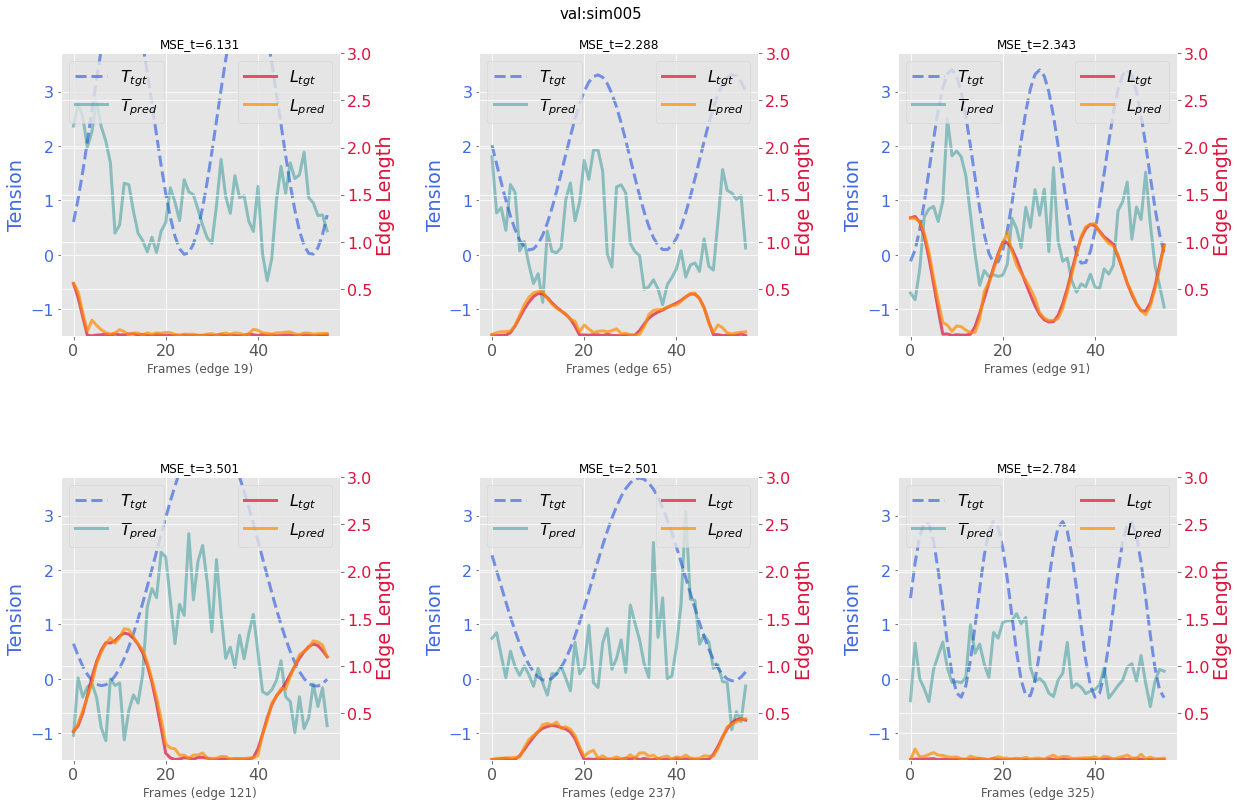

----------
 val:sim006



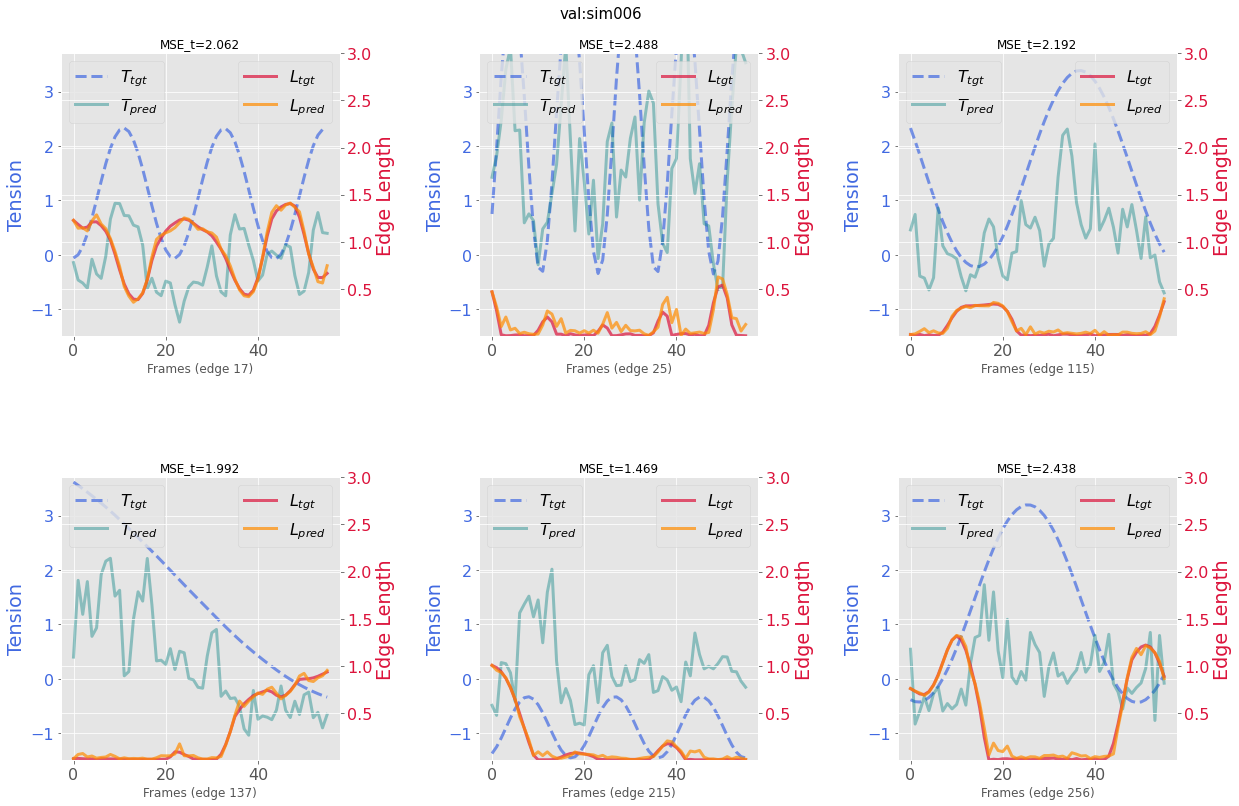

----------
 val2:sim005



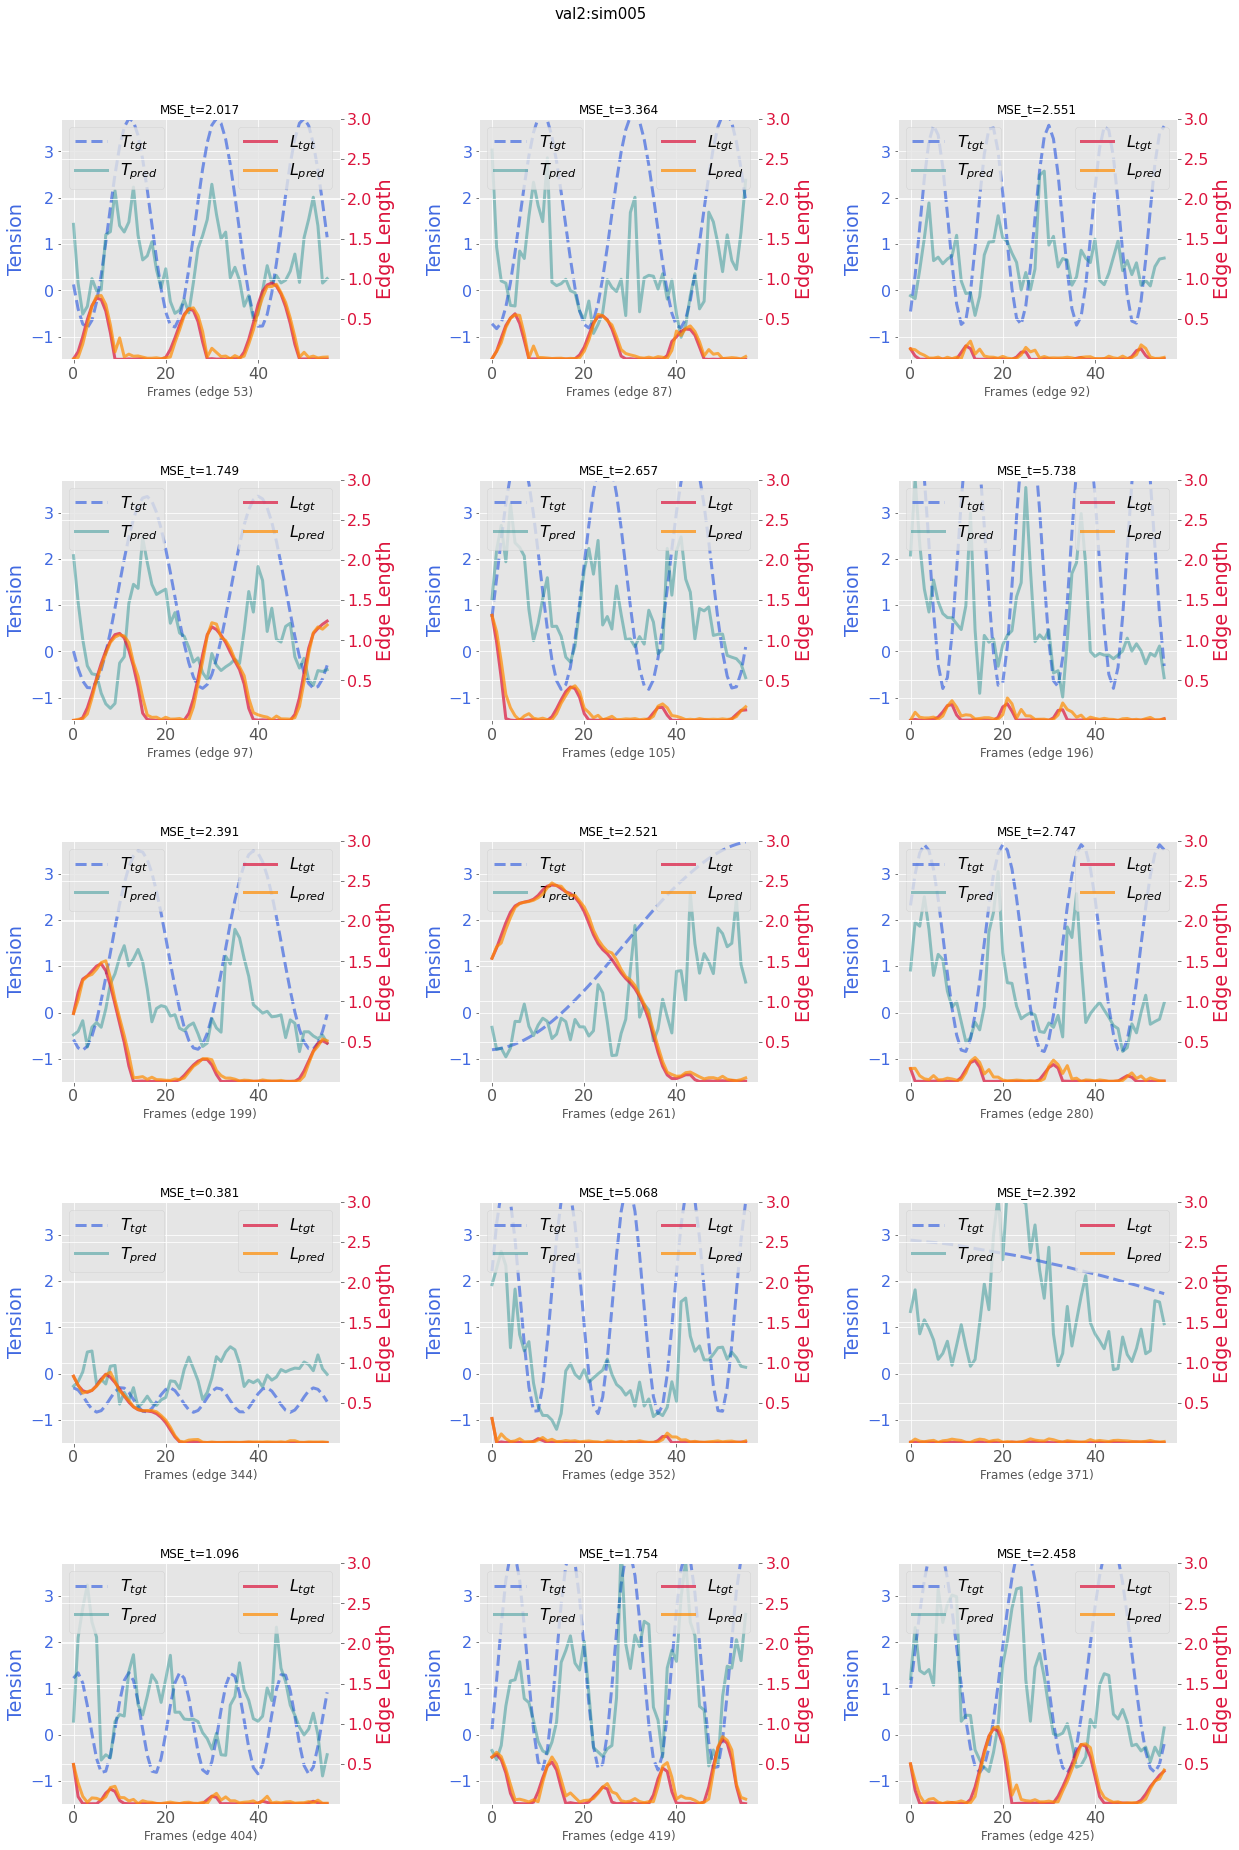

----------
 val2:sim006



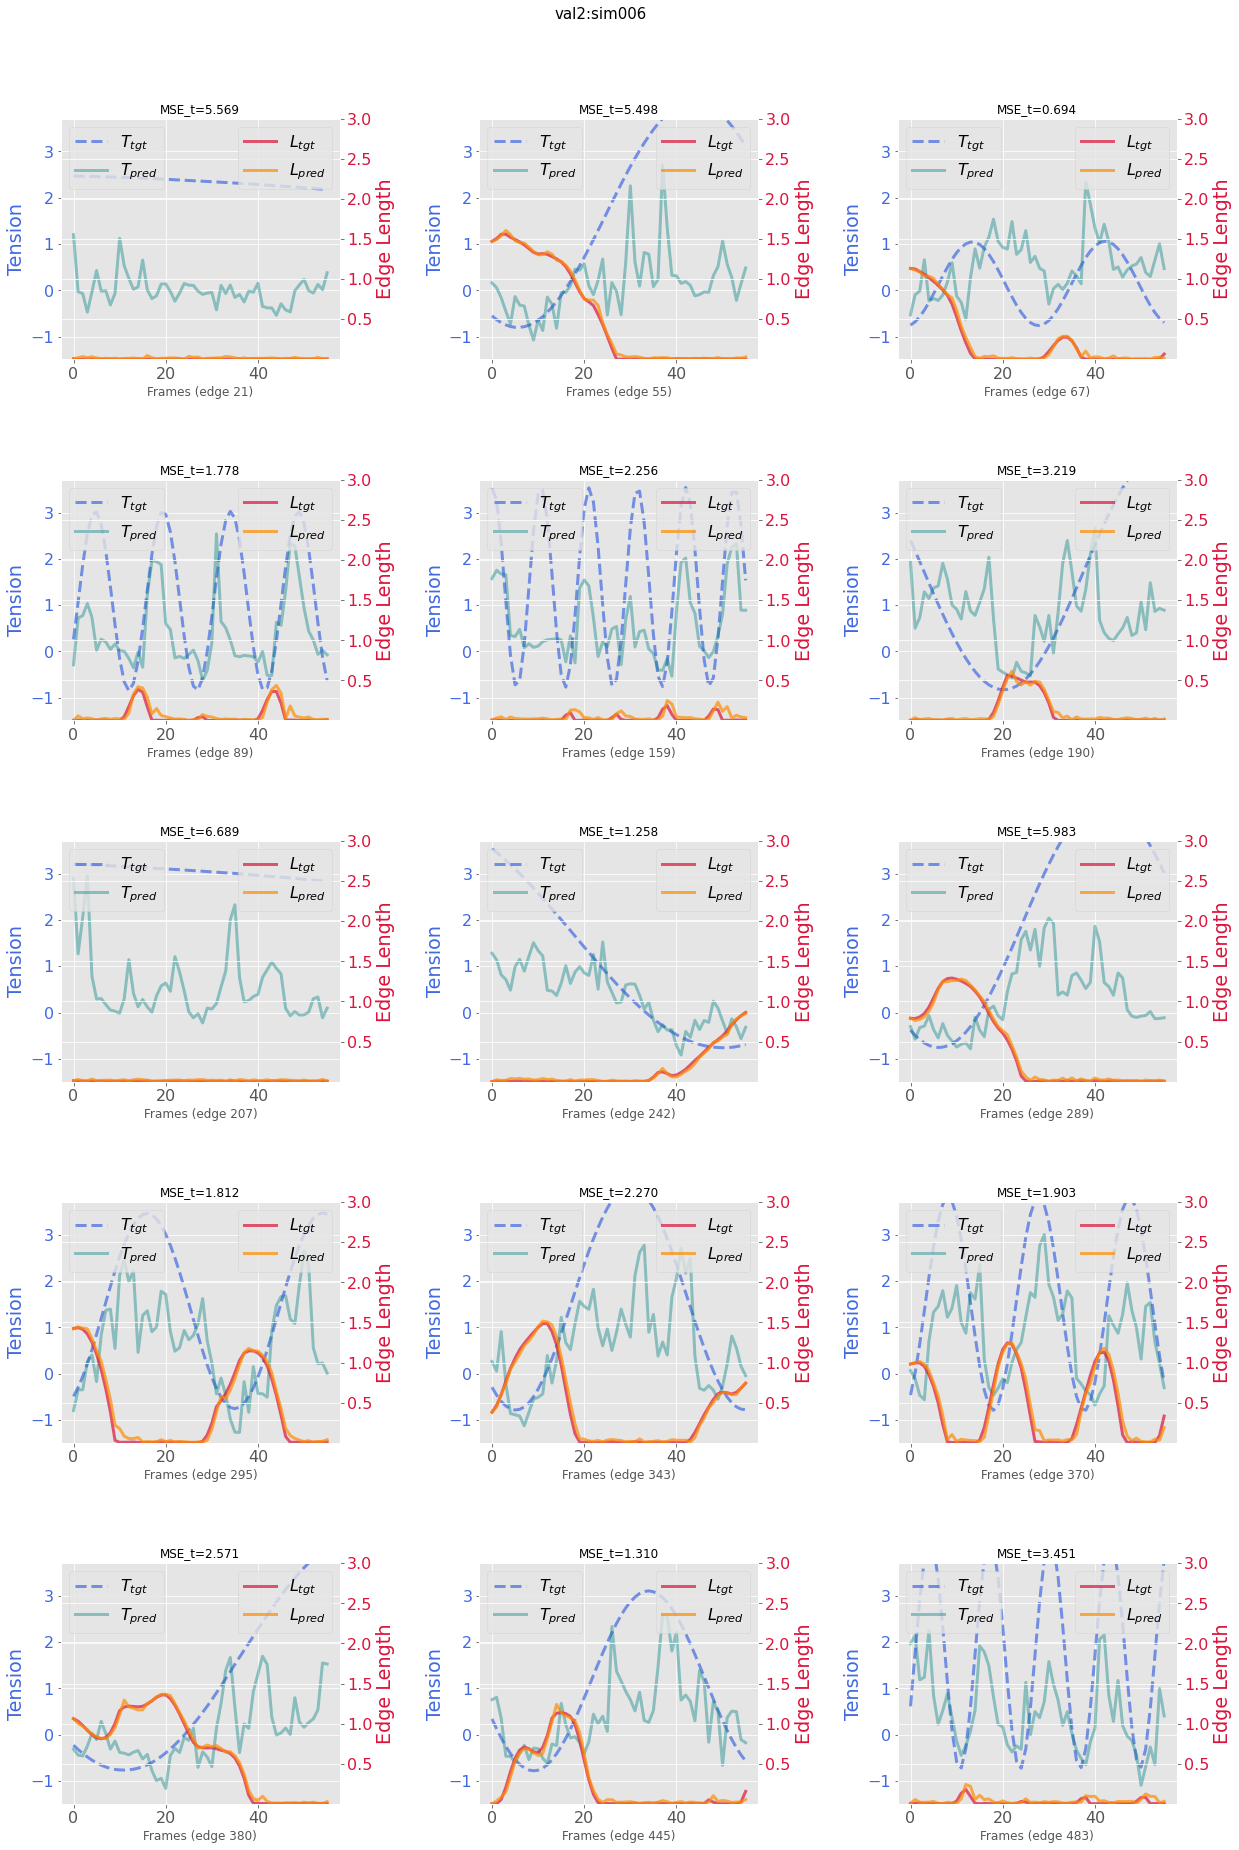

In [228]:
np.random.seed(0)
for dataname_k in tension_errors:
    for mov_k in tension_errors[dataname_k]:
        print('-'*10+'\n',f'{dataname_k}:{mov_k}\n')
        N_plots = min([3*(len(tension_errors[dataname_k][mov_k])//3), 15])
        
        e_ids = np.sort(np.random.choice(tension_errors[dataname_k][mov_k], size=(N_plots,), replace=False))
        
        fig, axs = plt.subplots(nrows=N_plots//3, ncols=3, figsize=[20, 6*(N_plots//3)+1], gridspec_kw={'wspace':.5, 'hspace':.5})

        for k, ax in zip(e_ids, axs.ravel()):
            # Edge tensions
            Te_tgt = model_results[dataname_k][mov_k]['targets']['tension'][:,k]
            Te_pred = model_results[dataname_k][mov_k]['predictions']['tension'][:,k]
            Te_loss = model_results[dataname_k][mov_k]['loss']['tension'][k] # Tension pred-n loss
            # Edge lengths
            Le_tgt = model_results[dataname_k][mov_k]['targets']['edge_lengths'][:,k]
            Le_pred = model_results[dataname_k][mov_k]['predictions']['edge_lengths'][:,k]
            
            p1, = ax.plot(Te_tgt, '--', c='royalblue', alpha=0.7, lw=3, label=r'$T_{tgt}$')
            ax.plot(Te_pred, c='teal', alpha=0.4, lw=3, label=r'$T_{pred}$')
            
            ax2 = ax.twinx()
            p2, = ax2.plot(Le_tgt, c='crimson', alpha=0.7, lw=3, label=r'$L_{tgt}$')
            ax2.plot(Le_pred, c='darkorange', alpha=0.7, lw=3, label=r'$L_{pred}$')
            
            ax.set_xlabel(f'Frames (edge {k})', fontsize=12)
            ax.set_title(f'MSE_t={Te_loss:.3f}', fontsize=12)
            ax.set_ylabel(r'Tension', color=p1.get_color())
            ax.tick_params(axis='y', labelcolor=p1.get_color())
            ax.set_ylim(var_limits['tension'][0], var_limits['tension'][1])
            
            ax2.set_ylabel(r'Edge Length', color=p2.get_color())
            ax2.tick_params(axis='y', labelcolor=p2.get_color())
            ax2.set_ylim(var_limits['edge_lengths'][0], var_limits['edge_lengths'][1])
            
            ax2.legend(loc='upper right')
            ax.legend(loc='upper left')
        plt.suptitle(f'{dataname_k}:{mov_k}', fontsize=15, y=0.93)
        # plt.savefig(f'./{dataname_k}_{mov_k}_tension_dynamics_prediction_LOW_error.png',dpi=100, bbox_inches="tight")
        plt.show()
        plt.close()